# Offensive Language in Social Media

This project is based on SemEval-2019 Task 6: Identifying and Categorizing
Offensive Language in Social Media. The project focuses on subtasks A and B. In
sub-task A, the goal is to discriminate between offensive and non-offensive posts. In
sub-task B, the focus is on identifying the type of offensive content in the post.
For more information about the task, datasets and evaluation check out:
task website:
https://sites.google.com/site/offensevalsharedtask/offenseval2019

paper: https://www.aclweb.org/anthology/S19-2010/

###**NLP week - NUIG**
Duy Nguyen (DCU), Andrew Neary (NUIG), Alberto Castagna (TCD), Andrea Rossi (UCC), Enda O'Shea (UL), Priya Rani (NUIG)


# Importing Libraries

In [49]:
import pandas as pd
import numpy as np

import spacy
import re

#First download SpaCy's en_core_web_md model then load 
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load() 

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,XGBRFClassifier

%matplotlib inline
import warnings
warnings.filterwarnings(action = 'ignore')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## Dataset

In [50]:
df = pd.read_csv("olid-training-v1.0.tsv", sep='\t')
df.head()

id                                              tweet  ... subtask_b subtask_c
0  86426  @USER She should ask a few native Americans wh...  ...       UNT       NaN
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...  ...       TIN       IND
2  16820  Amazon is investigating Chinese employees who ...  ...       NaN       NaN
3  62688  @USER Someone should'veTaken" this piece of sh...  ...       UNT       NaN
4  43605  @USER @USER Obama wanted liberals &amp; illega...  ...       NaN       NaN

[5 rows x 5 columns]

The description of the files can be found in the original zip filet: https://scholar.harvard.edu/malmasi/olid


Data Description:
==============

* **id** = id of the tweet

* **tweet** = text data(tweet)

* **subtask_a** = Classification for task A: OFFensive (**OFF**) or NOT offensive (**NOT**)

* **subtask_b** = Classification for task B: Targeted INsult (TIN) or UNTargeted (UNT)


* **subtask_c** = Classification for task C: INDividual (**IND**), GRouP (**GRP**) or OTHer (**OTH**)

# Examples of Hate Speech

In [51]:
# Adding text-length as a field in the dataset
df['text length'] = df['tweet'].apply(len)
df.head(10)

id  ... text length
0  86426  ...          71
1  90194  ...          67
2  16820  ...         182
3  62688  ...          65
4  43605  ...          72
5  97670  ...          33
6  77444  ...          32
7  52415  ...         176
8  45157  ...          26
9  13384  ...         138

[10 rows x 6 columns]

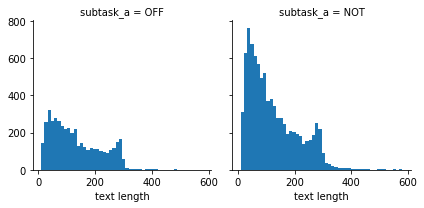

In [52]:
#Distribution over the length of the tweet
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=df, col='subtask_a')
graph.map(plt.hist, 'text length', bins=50)

- a.	Distribution of text-length almost seem to be similar across all two classes
- b.	Number of tweets seem to be skewed a lot higher towards the class-NOT


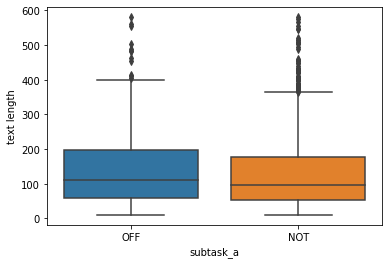

In [53]:
# Box-plot visualization
sns.boxplot(x='subtask_a', y='text length', data=df)

In [54]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=df.tweet
tweet.head()

0    @USER She should ask a few native Americans wh...
1    @USER @USER Go home you’re drunk!!! @USER #MAG...
2    Amazon is investigating Chinese employees who ...
3    @USER Someone should'veTaken" this piece of sh...
4    @USER @USER Obama wanted liberals &amp; illega...
Name: tweet, dtype: object

# Preprocessing of the tweets

In [55]:
# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
#retweet, fav, follow friday

nlp.Defaults.stop_words |= {"#ff", "ff", "rt",}

In [56]:
def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ") 
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')                   
    # remove leading and trailing whitespace 
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with number  
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
 
    # tokenizing
    tokenized_tweet = newtweet.apply(lambda x: x.split()) 
    
 
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p
   
processed_tweets = preprocess(tweet)

In [57]:
# Creating our tokenizer function
def spacy_tokenizer(processed_tweets):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(processed_tweets)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words ]

    # return preprocessed tokens
    return ' '.join(mytokens)

In [58]:
%%time
df['final_tweet'] = processed_tweets.apply(lambda x: spacy_tokenizer(x))

CPU times: user 16min 32s, sys: 13.4 s, total: 16min 46s
Wall time: 16min 45s


Dataset after the preprocessing operation

In [59]:
df.head(10)

id  ...                                        final_tweet
0  86426  ...                               ask native americans
1  90194  ...                          home drunk maga trump url
2  16820  ...  amazon investigate chinese employee sell inter...
3  62688  ...                         vetaken piece shit volcano
4  43605  ...           obama want liberal amp illegal red state
5  97670  ...                                     liberal kookoo
6  77444  ...                                 oh noes tough shit
7  52415  ...  literally talk lol mass shooting like set s pr...
8  45157  ...                                       buy icecream
9  13384  ...  canada doesn t need cuck looneyleft liberals f...

[10 rows x 7 columns]

In [60]:
final_tweet = df['final_tweet']

# Visualizations

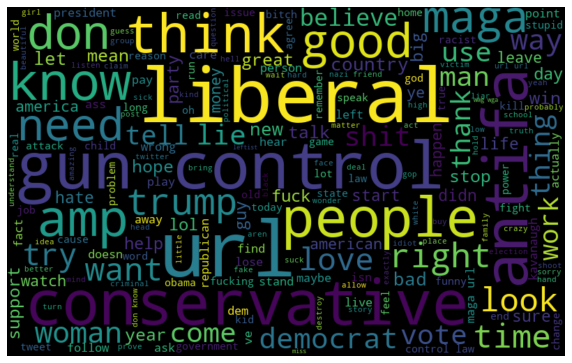

In [61]:
# visualizing which of the word is most commonly used in the twitter dataset

from wordcloud import WordCloud
all_words = ' '.join([text for text in df['final_tweet'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

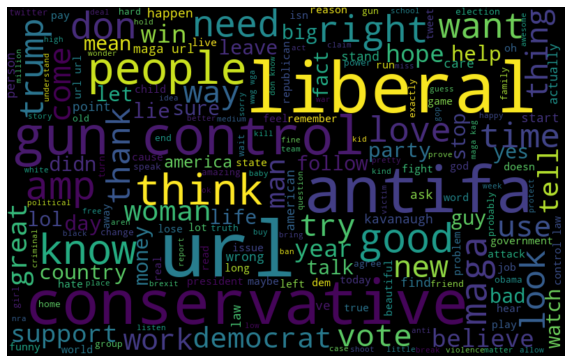

In [62]:
# visualizing which of the word is most commonly used for not offensive language


hatred_words = ' '.join([text for text in df['final_tweet'][df['subtask_a'] == "NOT"]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

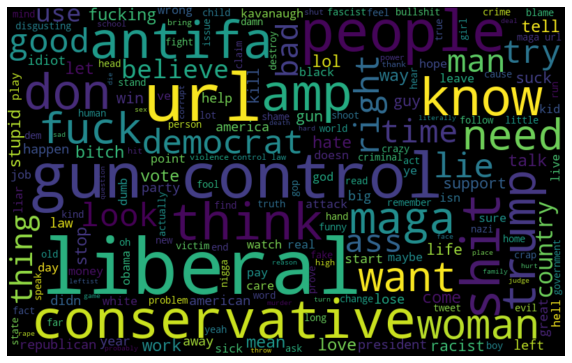

In [63]:
# visualizing which of the word is most commonly used for offensive language


offensive_words = ' '.join([text for text in df['final_tweet'][df['subtask_a'] == "OFF"]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# TF - IDF   Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF**: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

* **TF**($t$) = (Number of times term $t$ appears in a document) / (Total number of terms in the document).

**IDF**: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

* **IDF**($t$) = $log$(Total number of documents / Number of documents with term $t$ in it).

In [64]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=12000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(final_tweet)
tfidf

<13240x12000 sparse matrix of type '<class 'numpy.float64'>'
	with 127357 stored elements in Compressed Sparse Row format>

In [65]:
X = tfidf # the features we want to analyze
y = df['subtask_a'].values # the labels

# Running the models Using TFIDF

We fit three models: Logistic Regression, Random Forest and XGB.

In [66]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [67]:
%%time
clf = lr
train_lr_taska = clf.fit(X,y)

CPU times: user 587 ms, sys: 610 ms, total: 1.2 s
Wall time: 660 ms


In [68]:
%%time
clf = rf
train_rf_taska = clf.fit(X,y)

CPU times: user 20.5 s, sys: 111 ms, total: 20.7 s
Wall time: 20.6 s


In [69]:
%%time
clf = xgb
train_xgb_taska = clf.fit(X,y)

CPU times: user 2.8 s, sys: 4.9 ms, total: 2.8 s
Wall time: 2.79 s


Read the test set and process as the training set (pre-processing + embedding with tf_idf)

In [70]:
#read test set A:
testseta = pd.read_csv("testset-levela.tsv", sep='\t')

#extract tweet
tweet_seta=testseta.tweet
#preprocess
processed_tweets = preprocess(tweet_seta)

#tokenize tweet
tweet_seta['final_tweet'] = processed_tweets.apply(lambda x: spacy_tokenizer(x))
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# TF-IDF feature matrix for tweet_seta
tfidf_a = tfidf_vectorizer.fit_transform(tweet_seta['final_tweet'])

Xa = tfidf_a # the features we want to analyze

Prediction using the models


In [71]:
predicted_lr=train_lr_taska.predict(Xa)
predicted_rf=train_rf_taska.predict(Xa)
predicted_xgb=train_xgb_taska.predict(Xa)


Read the ground truth of the test set

In [72]:
expected_label= pd.read_csv("labels-levela.csv",header=None, index_col=None)

formatted_el=[]
for i in range(len(expected_label)):
    formatted_el.append(expected_label.iloc[i][1])
    

# Evaluation

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [74]:
print("LR SCORES")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_lr))))

print("OFF")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr),average = 'binary', pos_label="OFF")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr), pos_label="OFF")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr), pos_label="OFF")))

print("NOT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr),average = 'binary', pos_label="NOT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr), pos_label="NOT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr), pos_label="NOT")))


LR SCORES
f1 macro score is : 0.43033991056287124
accuracy is: 0.7197674418604652 
OFF
f1 score is : 0.024291497975708502
precision is: 0.42857142857142855 
recall is: 0.0125 
NOT
f1 score is : 0.836388323150034
precision is: 0.7221570926143025 
recall is: 0.9935483870967742 


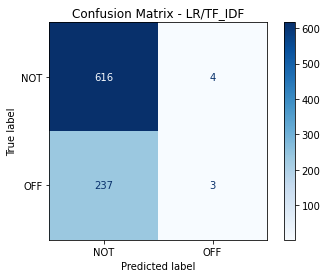

In [75]:
disp = plot_confusion_matrix(lr, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - LR/TF_IDF")
plt.show()

In [76]:
print("Random Forest Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_rf))))

print("OFF")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf),average = 'binary', pos_label="OFF")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf), pos_label="OFF")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf), pos_label="OFF")))

print("NOT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf),average = 'binary', pos_label="NOT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf), pos_label="NOT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf), pos_label="NOT")))


Random Forest Scores
f1 macro score is : 0.4623587717788187
accuracy is: 0.6790697674418604 
OFF
f1 score is : 0.12101910828025476
precision is: 0.25675675675675674 
recall is: 0.07916666666666666 
NOT
f1 score is : 0.8036984352773826
precision is: 0.7188295165394402 
recall is: 0.9112903225806451 


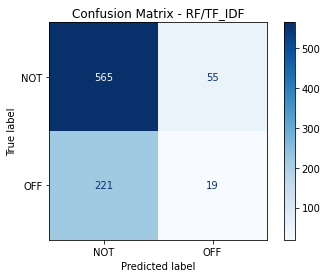

In [77]:
disp = plot_confusion_matrix(rf, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - RF/TF_IDF")
plt.show()

In [78]:
print("XGB Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_xgb))))

print("OFF")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb),average = 'binary', pos_label="OFF")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb), pos_label="OFF")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb), pos_label="OFF")))

print("NOT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb),average = 'binary', pos_label="NOT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb), pos_label="NOT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb), pos_label="NOT")))


XGB Scores
f1 macro score is : 0.43000455996352027
accuracy is: 0.7093023255813954 
OFF
f1 score is : 0.031007751937984496
precision is: 0.2222222222222222 
recall is: 0.016666666666666666 
NOT
f1 score is : 0.8290013679890561
precision is: 0.7197149643705463 
recall is: 0.9774193548387097 


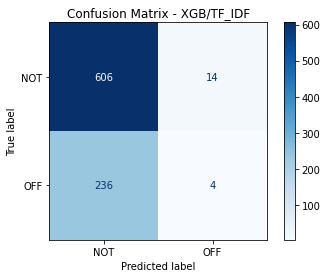

In [79]:
disp = plot_confusion_matrix(xgb, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - XGB/TF_IDF")
plt.show()

# Word2vec Implementation

* Word2vec groups the vector of similar words together in the vector space.
* That is it detects similarities mathematically.
* Given enough data, usage and contexts, word2vec can make highly accurate guesses about a word’s meaning based on past           appearances.
* Those guesses can be used to establish a word’s association with other words eg. “man” is to “boy” what “woman” is to “girl”.
* Each word is represented by a vector and in spaCy each vector has 300 dimensions [300 different properties associated,helpful while similarity matching]

In [80]:
def get_vec(x):
  doc = nlp(x)
  return doc.vector

In [81]:
new_dataset = df.drop(['subtask_a','tweet','text length'],axis = 1).copy()

In [82]:
%%time
new_dataset['vec'] = new_dataset['final_tweet'].apply(lambda x: get_vec(x))

CPU times: user 16min 22s, sys: 13.6 s, total: 16min 36s
Wall time: 16min 36s


In [84]:
XX = new_dataset['vec'].to_numpy()
XX = XX.reshape(-1,1)

In [85]:
XX = np.concatenate(np.concatenate(XX,axis = 0),axis = 0).reshape(-1,300)

In [87]:
yy = df['subtask_a'].values

# Running the models Using Word2vec

We fit three models: Logistic Regression, Random Forest and XGB.

In [88]:
lr1 = LogisticRegression()
rf1 = RandomForestClassifier()
xgb1 = XGBClassifier()

In [89]:
%%time
clf = lr1
train_lr1_taska = clf.fit(XX,yy)


CPU times: user 1.63 s, sys: 344 ms, total: 1.97 s
Wall time: 1.1 s


In [90]:
%%time
clf = rf1
train_rf1_taska = clf.fit(XX,yy)

CPU times: user 20.2 s, sys: 97.2 ms, total: 20.3 s
Wall time: 20.2 s


In [91]:
%%time
clf = xgb1
train_xgb1_taska = clf.fit(XX,yy)

CPU times: user 26.2 s, sys: 52.1 ms, total: 26.3 s
Wall time: 26.2 s


Read the test set and process as the training set (pre-processing + embedding with word2vec (implemented by spacy))

In [92]:
#read test set A:
new_testseta = pd.read_csv("testset-levela.tsv", sep='\t')


#extract tweet
new_tweet_seta=new_testseta.tweet

#preprocess
processed_tweets = preprocess(new_tweet_seta)

#tokenize tweet
new_testseta['final_tweet'] = processed_tweets.apply(lambda x: spacy_tokenizer(x))
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

new_testseta['vec'] = new_testseta['final_tweet'].apply(lambda x: get_vec(x))

Xa = new_testseta.vec # the features we want to analyze

Xa = new_testseta['vec'].to_numpy()
Xa = Xa.reshape(-1,1)

Xa = np.concatenate(np.concatenate(Xa,axis = 0),axis = 0).reshape(-1,300)

Prediction using the models


In [93]:
predicted_lr1=train_lr1_taska.predict(Xa)
predicted_rf1=train_rf1_taska.predict(Xa)
predicted_xgb1=train_xgb1_taska.predict(Xa)


Read the ground truth of the test set

In [94]:
expected_label= pd.read_csv("labels-levela.csv",header=None,index_col=None)

formatted_el=[]
for i in range(len(expected_label)):
    formatted_el.append(expected_label.iloc[i][1])
    


# Evaluation

In [95]:
print("LR SCORES")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr1),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_lr1))))

print("OFF")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr1),average = 'binary', pos_label="OFF")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr1), pos_label="OFF")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr1), pos_label="OFF")))

print("NOT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_lr1),average = 'binary', pos_label="NOT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_lr1), pos_label="NOT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_lr1), pos_label="NOT")))


LR SCORES
f1 macro score is : 0.6852361360022212
accuracy is: 0.7976744186046512 
OFF
f1 score is : 0.49710982658959535
precision is: 0.8113207547169812 
recall is: 0.35833333333333334 
NOT
f1 score is : 0.8733624454148471
precision is: 0.7957559681697612 
recall is: 0.967741935483871 


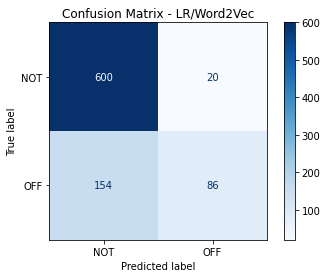

In [96]:
disp = plot_confusion_matrix(lr1, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - LR/Word2Vec")
plt.show()

In [97]:
print("Random Forest Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf1),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_rf1))))

print("OFF")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf1),average = 'binary', pos_label="OFF")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf1), pos_label="OFF")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf1), pos_label="OFF")))

print("NOT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_rf1),average = 'binary', pos_label="NOT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_rf1), pos_label="NOT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_rf1), pos_label="NOT")))


Random Forest Scores
f1 macro score is : 0.6673797469184226
accuracy is: 0.7941860465116279 
OFF
f1 score is : 0.4620060790273556
precision is: 0.8539325842696629 
recall is: 0.31666666666666665 
NOT
f1 score is : 0.8727534148094895
precision is: 0.7872892347600519 
recall is: 0.9790322580645161 


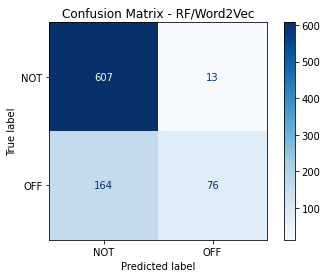

In [98]:
disp = plot_confusion_matrix(rf1, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - RF/Word2Vec")
plt.show()

In [99]:
print("XGB Scores")

print("f1 macro score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb1),average = 'macro')))#, pos_label="UNT")))

print("accuracy is: {} ".format(sklearn.metrics.accuracy_score((formatted_el),(predicted_xgb1))))

print("OFF")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb1),average = 'binary', pos_label="OFF")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb1), pos_label="OFF")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb1), pos_label="OFF")))

print("NOT")

print("f1 score is : {}".format(sklearn.metrics.f1_score((formatted_el),(predicted_xgb1),average = 'binary', pos_label="NOT")))

print("precision is: {} ".format(sklearn.metrics.precision_score((formatted_el),(predicted_xgb1), pos_label="NOT")))

print("recall is: {} ".format(sklearn.metrics.recall_score((formatted_el),(predicted_xgb1), pos_label="NOT")))


XGB Scores
f1 macro score is : 0.7197374736081183
accuracy is: 0.8081395348837209 
OFF
f1 score is : 0.5623342175066314
precision is: 0.7737226277372263 
recall is: 0.44166666666666665 
NOT
f1 score is : 0.8771407297096053
precision is: 0.8146611341632088 
recall is: 0.95 


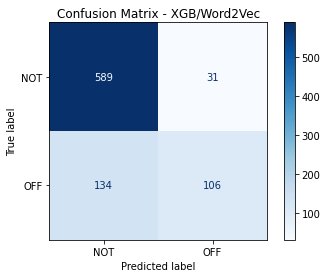

In [100]:
disp = plot_confusion_matrix(xgb1, Xa, formatted_el,
                             values_format='.0f', 
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix - XGB/Word2Vec")
plt.show()

# Model Explanation

In [101]:
!pip3 install eli5
import eli5

     |████████████████████████████████| 112kB 5.1MB/s 


In [102]:
eli5.show_weights(lr,vec=tfidf_vectorizer,top=15)  # logistic regression
# will give you top 15 features or words   


In [103]:
eli5.show_weights(xgb,vec=tfidf_vectorizer,top=15)  # XGBoost
# will give you top 15 features or words   

# Tweets Explanation

In [104]:
final_tweet[1]

'home drunk maga trump url'

In [105]:
eli5.show_prediction(rf ,vec = tfidf_vectorizer,doc =final_tweet[1]) 